In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from enum import Enum
import glob
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input
from collections import Counter

import re

In [32]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
def parse_confusion_matrix_from_text(file_path):
  # Read the file and extract the lines representing the confusion matrix
  with open(file_path, 'r') as file:
    lines = file.readlines()  # Assuming the matrix starts from the 2nd line and ends at the 4th line
  # Convert the lines to a list of lists (confusion matrix)

  confusion_matrix = [[int(value) for value in re.sub(r"[^0-9\s]", "", line).split()] for line in lines[1:4]]
  line = lines[6]
  #print(line)
  line = line.strip()
  confusion_classes = line[line.index('[')+1:line.index(']')].split(', ')
  # Remove single quotes from each word
  confusion_classes = [word.strip("'") for word in confusion_classes]

  return [confusion_classes, confusion_matrix]



def get_precision_recall_f1(file_path, my_class):
  with open(file_path, 'r') as file:
    for line in file:
      if line.strip().startswith(my_class):
        words = line.strip().split()
        try:
          float_words = [float(word) for word in words[1:4]]
          return float_words
        except ValueError:
          return None
    return None


def get_precision_recall_f1_from_row(row, my_class):
  file_path = os.path.join(row['folder_name'], 'test_data_confusion_plot.txt')
  return get_precision_recall_f1(file_path, my_class)

def extract_metrics(row):
  #print(row)
  file_path = os.path.join(row['folder_name'], 'metrics_test inference.txt')
  #print("file_path")
  with open(file_path, 'r') as f:
    lines = f.readlines()
    #loss_index = lines.index("Metric Names: \n") + 2
    values_index = lines.index("Metrics: \n") +1
    line = lines[values_index].strip('[],\n ')
    metrics_list = [float(x) for x in line.split(",")]
    loss = metrics_list[0]
    accuracy = metrics_list[1]
  return pd.Series({'test_loss': loss, 'test_accuracy': accuracy})




In [34]:
num_epochs = 24
#agument_data means to add data ahead of time.  This should be off
# if you don't even want to balance the dataset
augment_data = [True, False]
continuous_augmentation = [True, False]
extra_to_majority = [0, 2000]
artificially_reduce_malignant_rate = [0.0, .8]
#order continuous_augmentation , augment_data, extra_to_majority, artificially_reduce_malignant_rate
params_to_plot = [
    [False, False, 0, 0.0], #No balancing, without continuous
    [True, False, 0, 0.0], #No balancing with continuous
    [False, True, 0, 0.0], #balancing , without continuous
    [True, True, 0, 0.0], #balancing with continuous
    [False, True, 2000, 0.0], #2,000 extra , without continuous
    [True, True, 2000, 0.0], #2,000 extra with continuous
    [False, True, 2000, 0.5], #8 2,000 extra, with 50% reduction, without continuous
    [True, True, 2000, 0.5], #2,000 extra, with 50% reduction, with continuous
    [False, True, 2000, 0.65], #10 2,000 extra, with 65% reduction, without continuous
    [True, True, 2000, 0.65], #2,000 extra, with 65% reduction, with continuous
    [False, True, 2000, 0.8], #2,000 extra, with 80% reduction, without continuous
    [True, True, 2000, 0.8], #2,000 extra, with 80% reduction, with continuous
    [False, True, 2000, 0.95], #8 2,000 extra, with 95% reduction, without continuous
    [True, True, 2000, 0.95], #2,000 extra, with 95% reduction, with continuous
]
headers = ["continuous_augmentation", "augment_data", "extra_to_majority", "reduce_malignant_rate"]
df_runs = pd.DataFrame(params_to_plot, columns=headers)

base_output_directory = './drive/MyDrive/ML/BreastCancerProject/report/'
df_runs["folder_name"] = df_runs.apply(lambda curr: base_output_directory+
                             'b_aug_data_' +
                             str(curr["augment_data"]) +
                             '_continuous_' +
                             str(curr["continuous_augmentation"]) +
                             '_extra_' + str(curr["extra_to_majority"]) +
                             '_malreduction_' +
                             str(curr["reduce_malignant_rate"]),
                             axis=1)

df_runs.head(14)


,continuous_augmentation,augment_data,extra_to_majority,reduce_malignant_rate,folder_name
0,False,False,0,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...
1,True,False,0,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...
2,False,True,0,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...
3,True,True,0,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...
4,False,True,2000,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...
5,True,True,2000,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...
6,False,True,2000,0.50,./drive/MyDrive/ML/BreastCancerProject/report/...
7,True,True,2000,0.50,./drive/MyDrive/ML/BreastCancerProject/report/...
8,False,True,2000,0.65,./drive/MyDrive/ML/BreastCancerProject/report/...
9,True,True,2000,0.65,./drive/MyDrive/ML/BreastCancerProject/report/...


In [35]:
df_runs[['test_loss', 'test_accuracy']] = df_runs.apply(extract_metrics, axis=1)
classes = ['benign', 'malignant', 'normal']
for c in classes:
  result = df_runs.apply(lambda row: get_precision_recall_f1_from_row(row, c), axis=1)
  #df_runs[[c+'_precision', c+'_recall', c+'_f1']] = df_runs.apply(lambda row: get_precision_recall_f1_from_row(row, c), axis=1)
  df_runs[[c+'_precision', c+'_recall', c+'_f1']] = pd.DataFrame(result.tolist(), index=df_runs.index)

df_runs.head(14)

,continuous_augmentation,augment_data,extra_to_majority,reduce_malignant_rate,folder_name,test_loss,test_accuracy,benign_precision,benign_recall,benign_f1,malignant_precision,malignant_recall,malignant_f1,normal_precision,normal_recall,normal_f1
0,False,False,0,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...,0.959761,0.557692,0.68,0.71,0.70,0.45,0.40,0.42,0.33,0.34,0.34
1,True,False,0,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...,0.525052,0.762821,0.74,0.89,0.81,0.77,0.70,0.73,0.88,0.48,0.62
2,False,True,0,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...,0.938238,0.551282,0.56,0.94,0.70,0.50,0.12,0.19,0.50,0.07,0.12
3,True,True,0,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...,0.384353,0.852564,0.90,0.85,0.87,0.78,0.84,0.81,0.84,0.90,0.87
4,False,True,2000,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...,0.378444,0.910256,0.90,0.94,0.92,0.91,0.91,0.91,0.96,0.83,0.89
5,True,True,2000,0.00,./drive/MyDrive/ML/BreastCancerProject/report/...,0.388949,0.865385,0.90,0.86,0.88,0.86,0.86,0.86,0.79,0.90,0.84
6,False,True,2000,0.50,./drive/MyDrive/ML/BreastCancerProject/report/...,0.708555,0.891026,0.89,0.94,0.91,0.88,0.81,0.84,0.93,0.86,0.89
7,True,True,2000,0.50,./drive/MyDrive/ML/BreastCancerProject/report/...,0.373632,0.897436,0.94,0.89,0.91,0.86,0.86,0.86,0.85,0.97,0.90
8,False,True,2000,0.65,./drive/MyDrive/ML/BreastCancerProject/report/...,0.687342,0.750000,0.71,0.98,0.82,0.78,0.42,0.55,1.00,0.59,0.74
9,True,True,2000,0.65,./drive/MyDrive/ML/BreastCancerProject/report/...,0.573177,0.852564,0.88,0.92,0.90,0.93,0.63,0.75,0.74,1.00,0.85


In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def form_title(row, i, j):
  t=""
  if i == 0:
    if j == 0:
      t="Continuous Augmentation = False\n\n"
    else:
      t="Continuous Augmentation = False\n\n"
  t += f"Accuracy = {row['test_accuracy']:.2f}"
  t += f"\nMalignant Precision = {row['malignant_precision']:.2f}"
  t += f"\nMalignant Recall = {row['malignant_recall']:.2f}"
  t += f"\nMalignant F1 = {row['malignant_f1']:.2f}"
  return t


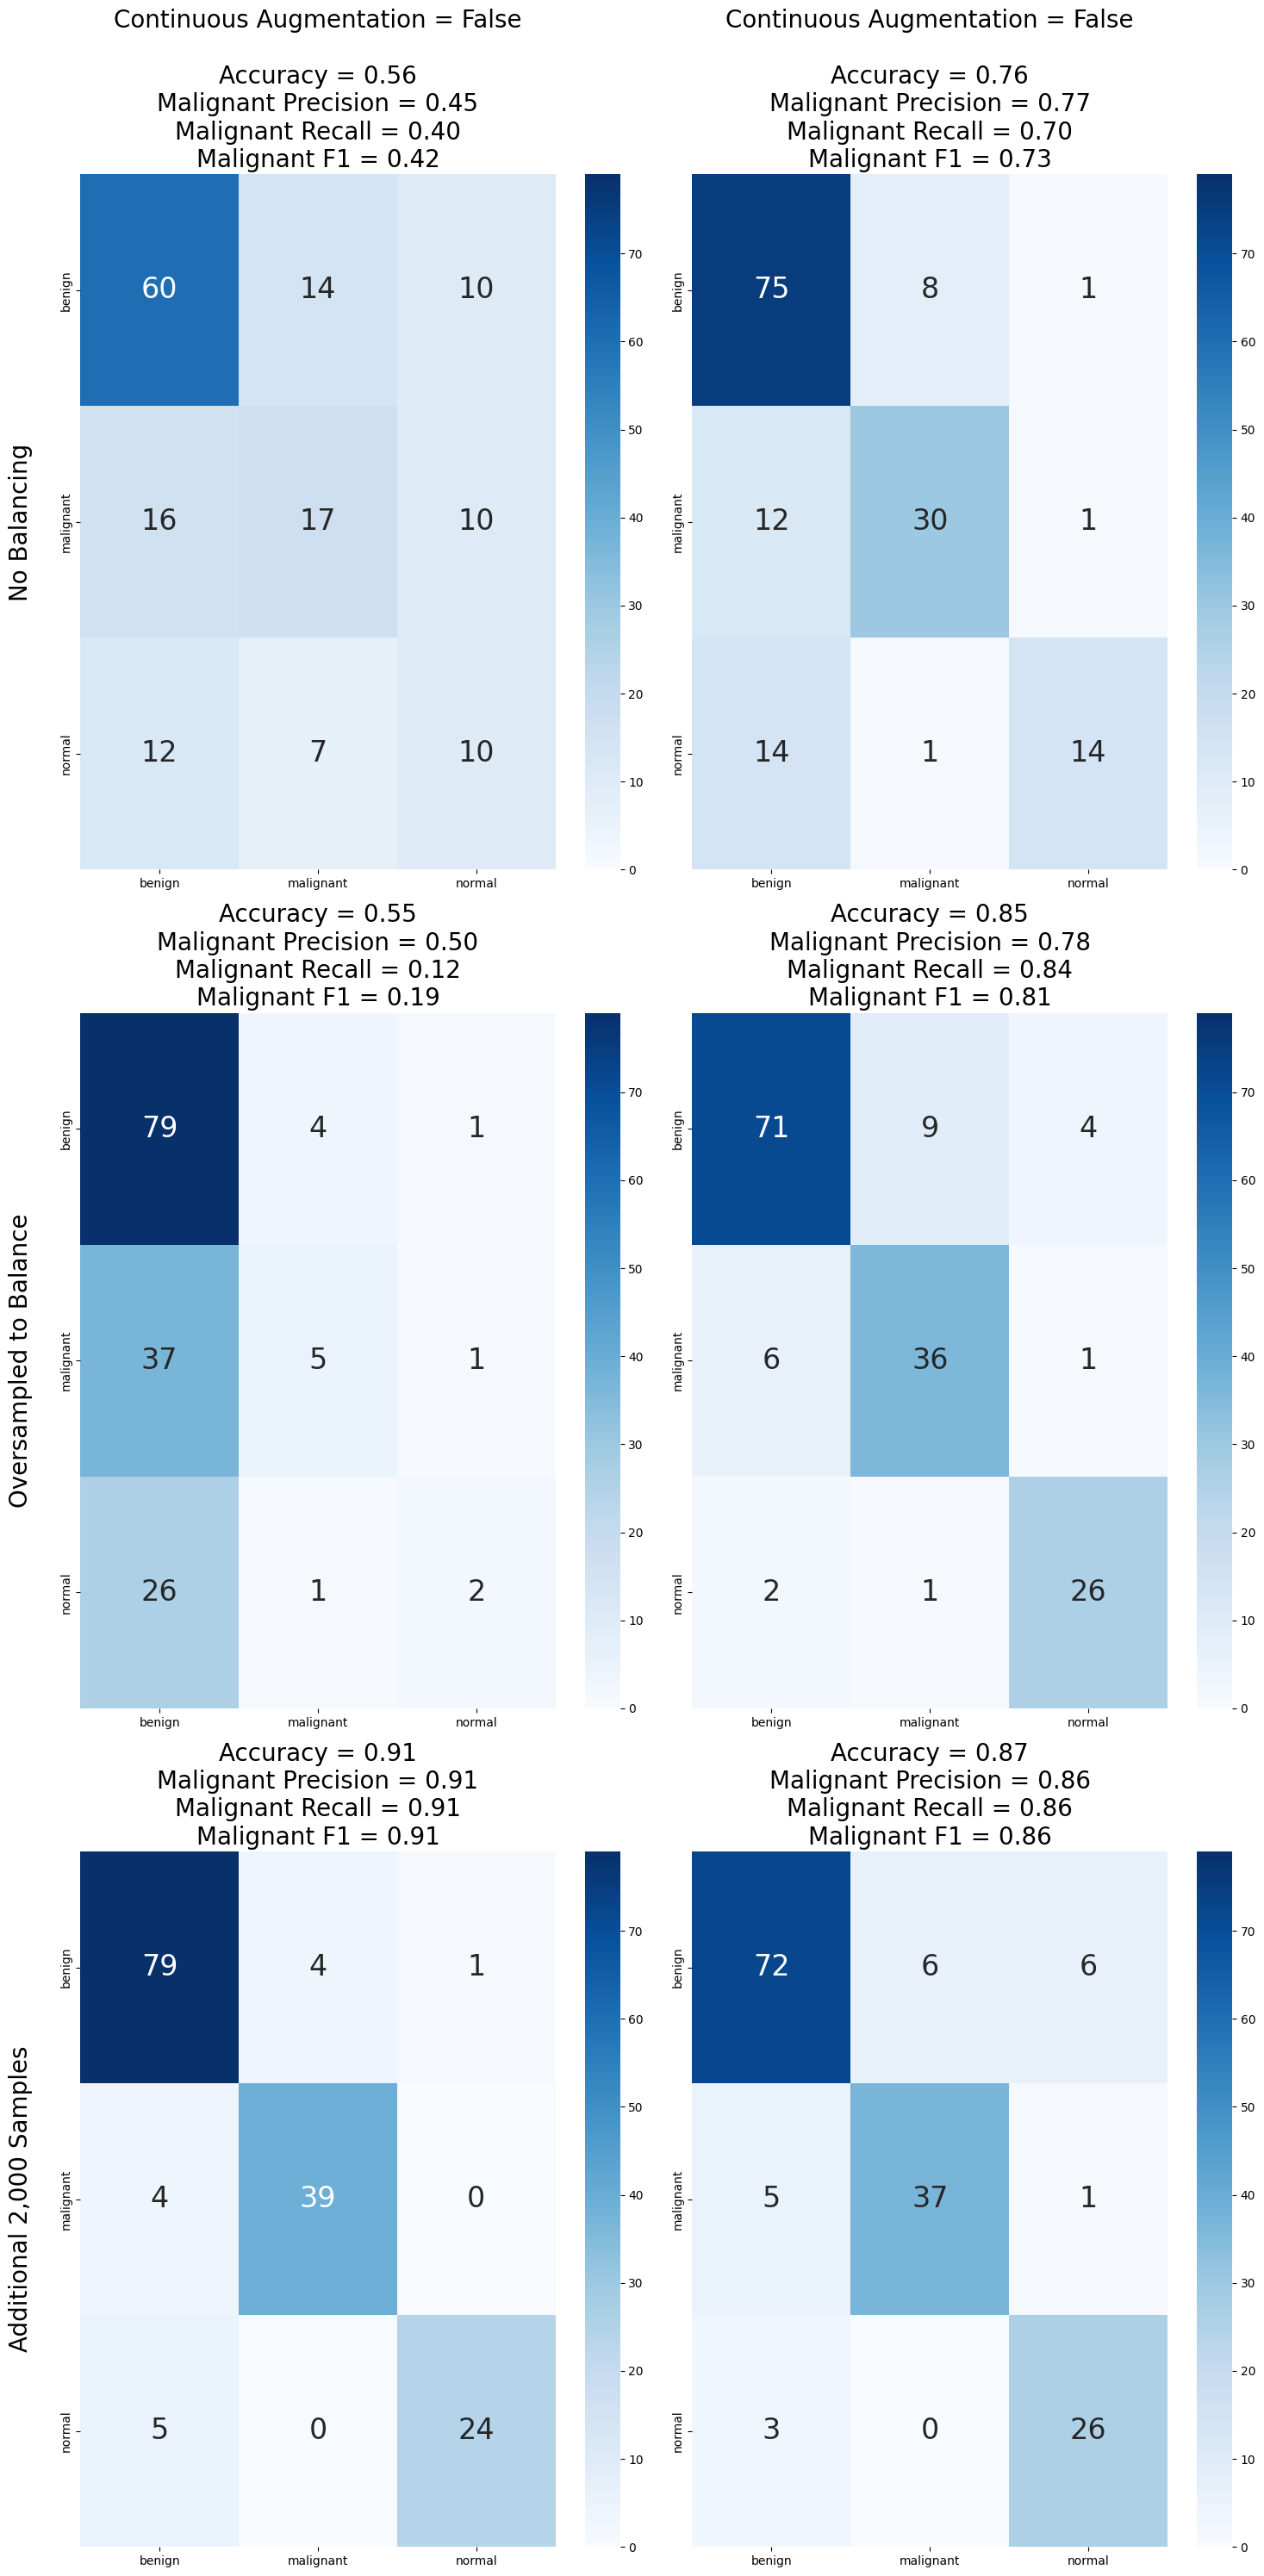

In [37]:

row_labels = [
    "No Balancing",
    "Oversampled to Balance",
    "Additional 2,000 Samples",
   # "Malignant Class Undersampled by 80%\nThen Additional 2,000 Generated"
]
df_curr = df_runs[0:6]
num_rows = len(df_curr)//2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))#sharex=True, sharey=True)
#tight_layout=True
# Add title
#fig.suptitle("Model Performance on Test Data", fontsize=16)
max_val = 1
for i, row in df_curr.iterrows():
    #image_path = row['folder_name'] + "/test_data_confusion_plot.png"
    confusion_path = row['folder_name'] + "/test_data_confusion_plot.txt"
    confusion_classes, confusion_matrix = parse_confusion_matrix_from_text(confusion_path)
    max_val = max(max_val,max([max(sub_list) for sub_list in confusion_matrix]))
for i, row in df_curr.iterrows():
    #image_path = row['folder_name'] + "/test_data_confusion_plot.png"
    confusion_path = row['folder_name'] + "/test_data_confusion_plot.txt"
    confusion_classes, confusion_matrix = parse_confusion_matrix_from_text(confusion_path)
    ax = axes[i // num_cols, i % num_cols]
    sns.heatmap(confusion_matrix, annot=True,
                fmt='d', cmap='Blues',
                xticklabels=confusion_classes,
                yticklabels=confusion_classes,
                ax=ax,vmin=0, vmax=max_val,
                annot_kws={"size": 24})
    #ax.set_xlabel('Predicted Label')
    #ax.set_ylabel('True Label')
    ax.set_title(form_title(row,i // num_cols, i % num_cols) , fontsize=20)
    #ax.axis('off')
    # Remove ticks from x-axis
    #ax.set_xticks([])

    # Remove ticks from y-axis
    #ax.set_yticks([])

    # Add vertical labels
    if i%2 < 1:
      ax.set_ylabel(row_labels[i//2], rotation=90, fontsize=20)
      ax.yaxis.set_label_coords(-0.1, 0.5)  # Adjust the position of the ylabel

# Add labels above columns
#axes[0, 0].set_title("Continuous Augmentation = False", fontsize=12)
#axes[0, 1].set_title("Continuous Augmentation = True", fontsize=12)

plt.tight_layout()
plt.show()

5
0
1
2
3
4
5
6
7
8
9


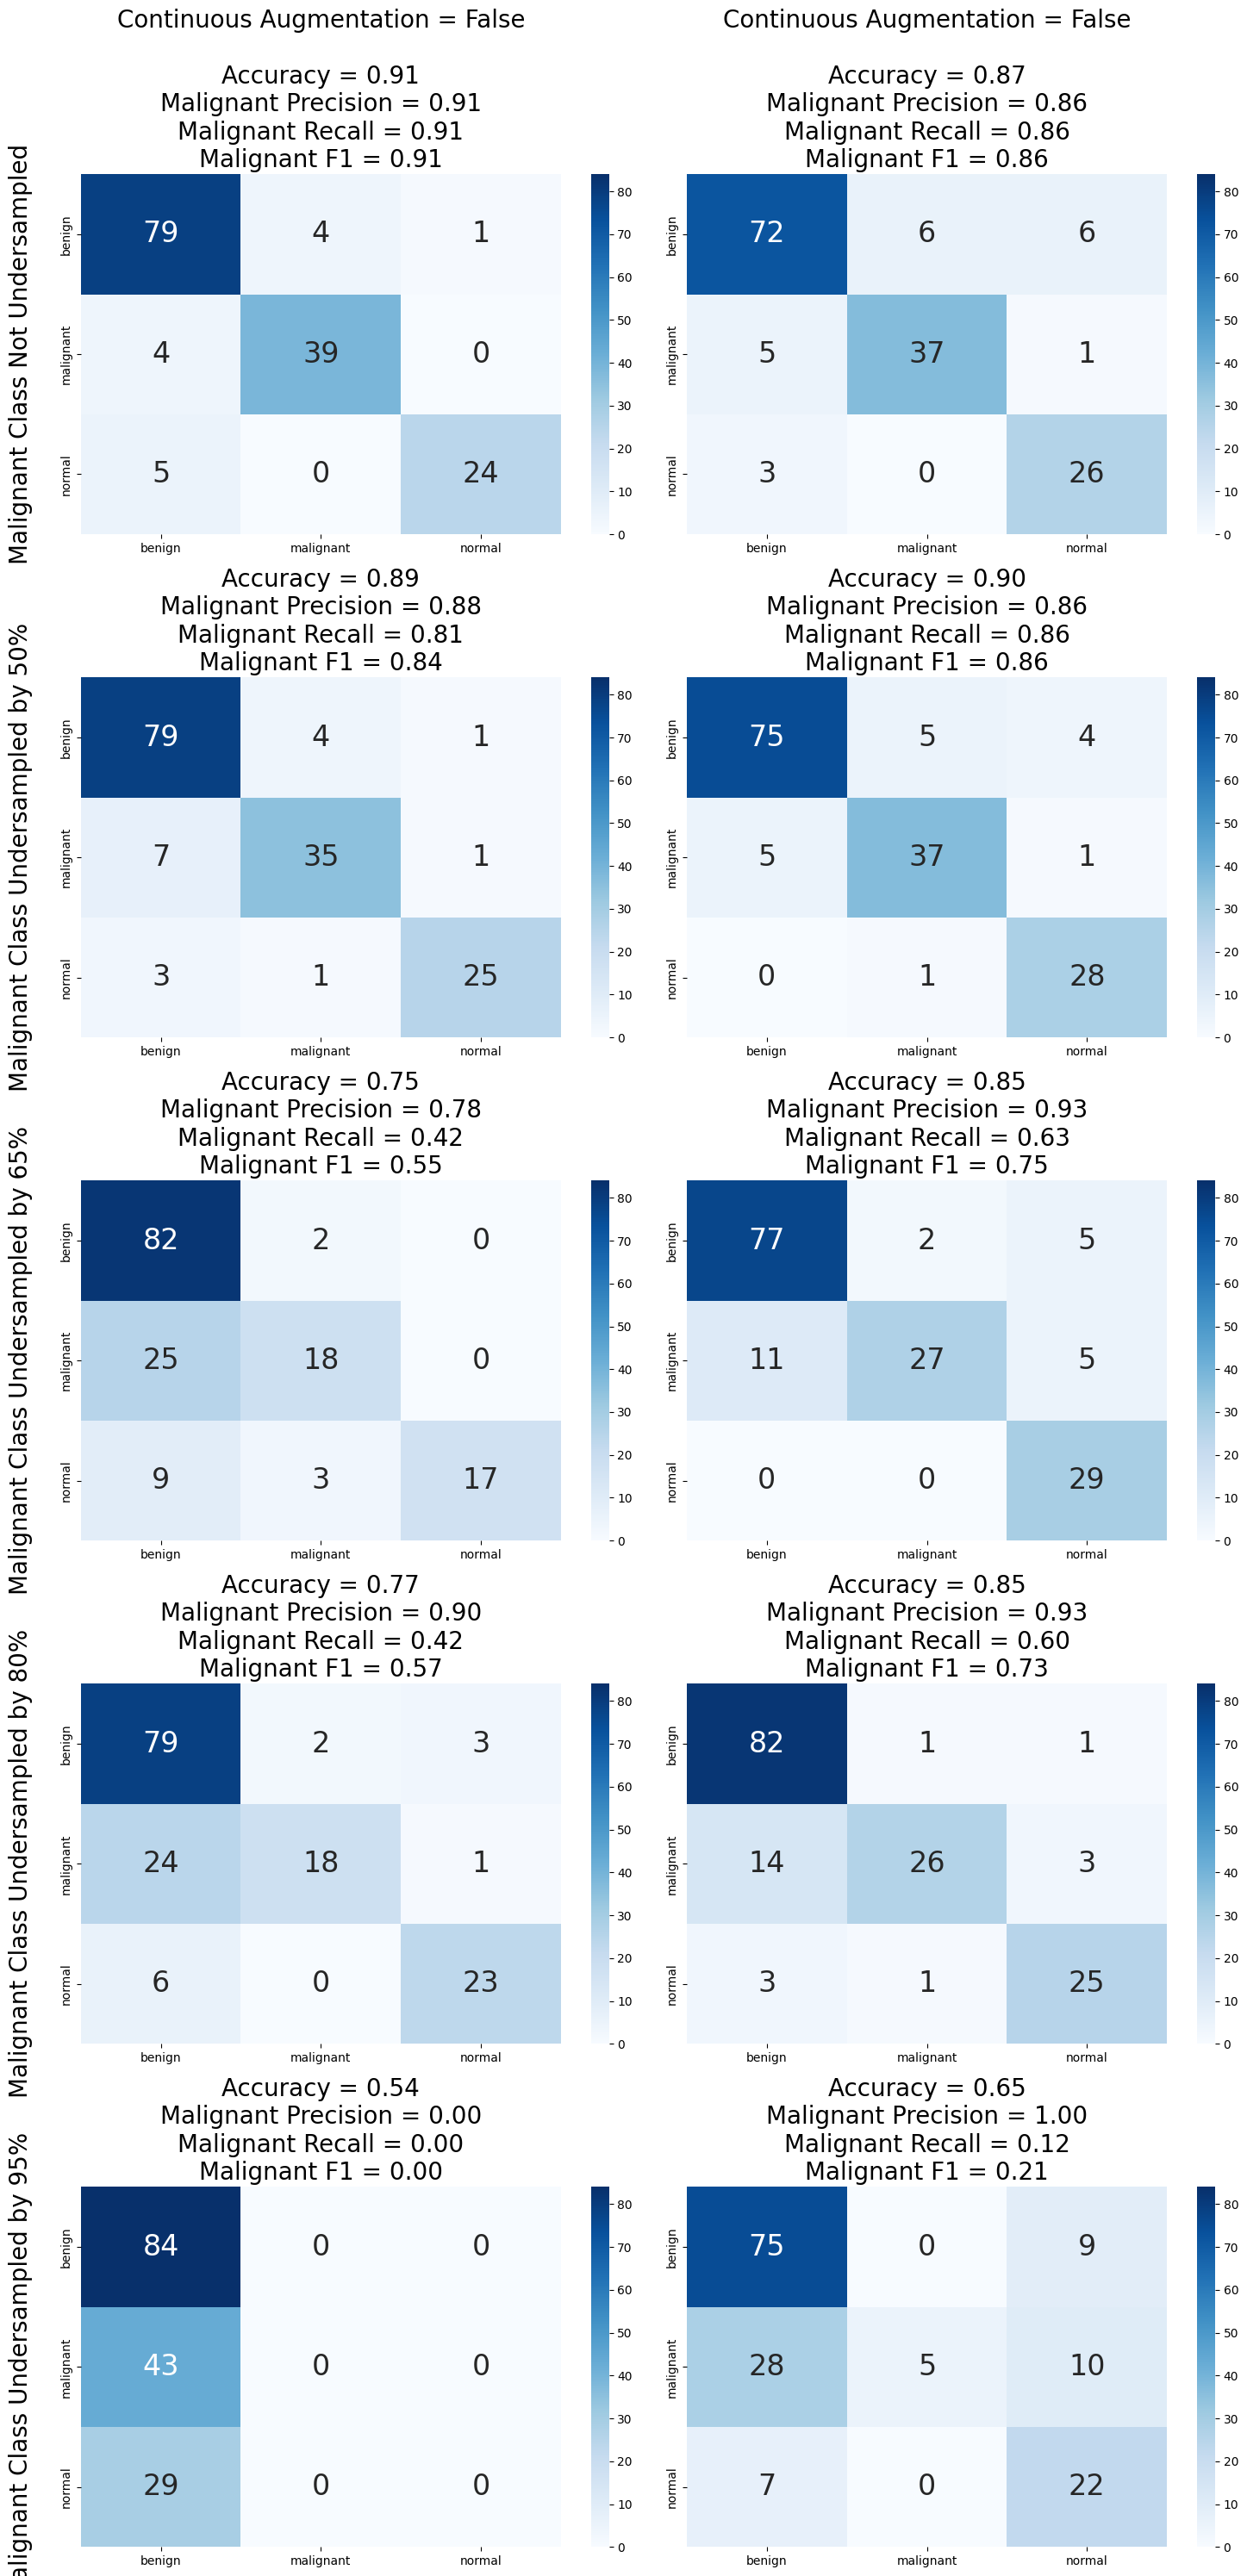

In [38]:

row_labels = [
    "Malignant Class Not Undersampled",
    "Malignant Class Undersampled by 50%",
    "Malignant Class Undersampled by 65%",
    "Malignant Class Undersampled by 80%",
    "Malignant Class Undersampled by 95%",
]
df_reduction_study = df_runs[4:14]
num_rows = len(df_reduction_study)//2
print(num_rows)
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))#sharex=True, sharey=True)
#tight_layout=True
# Add title
#fig.suptitle("Model Performance on Test Data", fontsize=16)
max_val = 1
for i, row in df_reduction_study.iterrows():
    #image_path = row['folder_name'] + "/test_data_confusion_plot.png"
    confusion_path = row['folder_name'] + "/test_data_confusion_plot.txt"
    confusion_classes, confusion_matrix = parse_confusion_matrix_from_text(confusion_path)
    max_val = max(max_val,max([max(sub_list) for sub_list in confusion_matrix]))
i = -1
for i_fake, row in df_reduction_study.iterrows():
    i = i + 1
    #image_path = row['folder_name'] + "/test_data_confusion_plot.png"
    confusion_path = row['folder_name'] + "/test_data_confusion_plot.txt"
    confusion_classes, confusion_matrix = parse_confusion_matrix_from_text(confusion_path)
    print(i)
    ax = axes[i // num_cols, i % num_cols]
    sns.heatmap(confusion_matrix, annot=True,
                fmt='d', cmap='Blues',
                xticklabels=confusion_classes,
                yticklabels=confusion_classes,
                ax=ax,vmin=0, vmax=max_val,
                annot_kws={"size": 24})
    #ax.set_xlabel('Predicted Label')
    #ax.set_ylabel('True Label')
    ax.set_title(form_title(row,i // num_cols, i % num_cols) , fontsize=20)
    #ax.axis('off')
    # Remove ticks from x-axis
    #ax.set_xticks([])

    # Remove ticks from y-axis
    #ax.set_yticks([])

    # Add vertical labels
    if i%2 < 1:
      ax.set_ylabel(row_labels[i//2], rotation=90, fontsize=20)
      ax.yaxis.set_label_coords(-0.1, 0.5)  # Adjust the position of the ylabel

# Add labels above columns
#axes[0, 0].set_title("Continuous Augmentation = False", fontsize=12)
#axes[0, 1].set_title("Continuous Augmentation = True", fontsize=12)

plt.tight_layout()
plt.show()

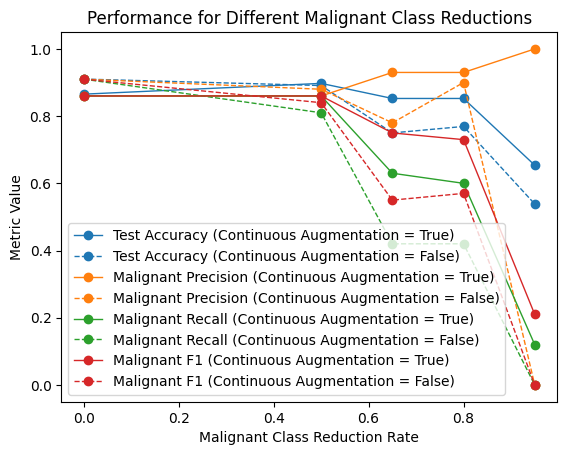

In [39]:

# Separate the dataframe based on continuous_augmentation value
df_true = df_reduction_study[df_reduction_study['continuous_augmentation'] == True]
df_false = df_reduction_study[df_reduction_study['continuous_augmentation'] == False]

# Plot the performance metrics for continuous_augmentation = True
plt.plot(df_true['reduce_malignant_rate'], df_true['test_accuracy'], label='Test Accuracy (Continuous Augmentation = True)', color='C0', linewidth=1, marker='o')
plt.plot(df_false['reduce_malignant_rate'], df_false['test_accuracy'], '--', label='Test Accuracy (Continuous Augmentation = False)', color='C0', linewidth=1, marker='o')

plt.plot(df_true['reduce_malignant_rate'], df_true['malignant_precision'], label='Malignant Precision (Continuous Augmentation = True)', color='C1', linewidth=1, marker='o')
plt.plot(df_false['reduce_malignant_rate'], df_false['malignant_precision'], '--', label='Malignant Precision (Continuous Augmentation = False)', color='C1', linewidth=1, marker='o')

plt.plot(df_true['reduce_malignant_rate'], df_true['malignant_recall'], label='Malignant Recall (Continuous Augmentation = True)', color='C2', linewidth=1, marker='o')
plt.plot(df_false['reduce_malignant_rate'], df_false['malignant_recall'], '--', label='Malignant Recall (Continuous Augmentation = False)', color='C2', linewidth=1, marker='o')

plt.plot(df_true['reduce_malignant_rate'], df_true['malignant_f1'], label='Malignant F1 (Continuous Augmentation = True)', color='C3', linewidth=1, marker='o')
plt.plot(df_false['reduce_malignant_rate'], df_false['malignant_f1'], '--', label='Malignant F1 (Continuous Augmentation = False)', color='C3', linewidth=1, marker='o')

# Set the title and labels
plt.title('Performance for Different Malignant Class Reductions')
plt.xlabel('Malignant Class Reduction Rate')
plt.ylabel('Metric Value')

# Add a legend
plt.legend()

# Display the plot
plt.show()


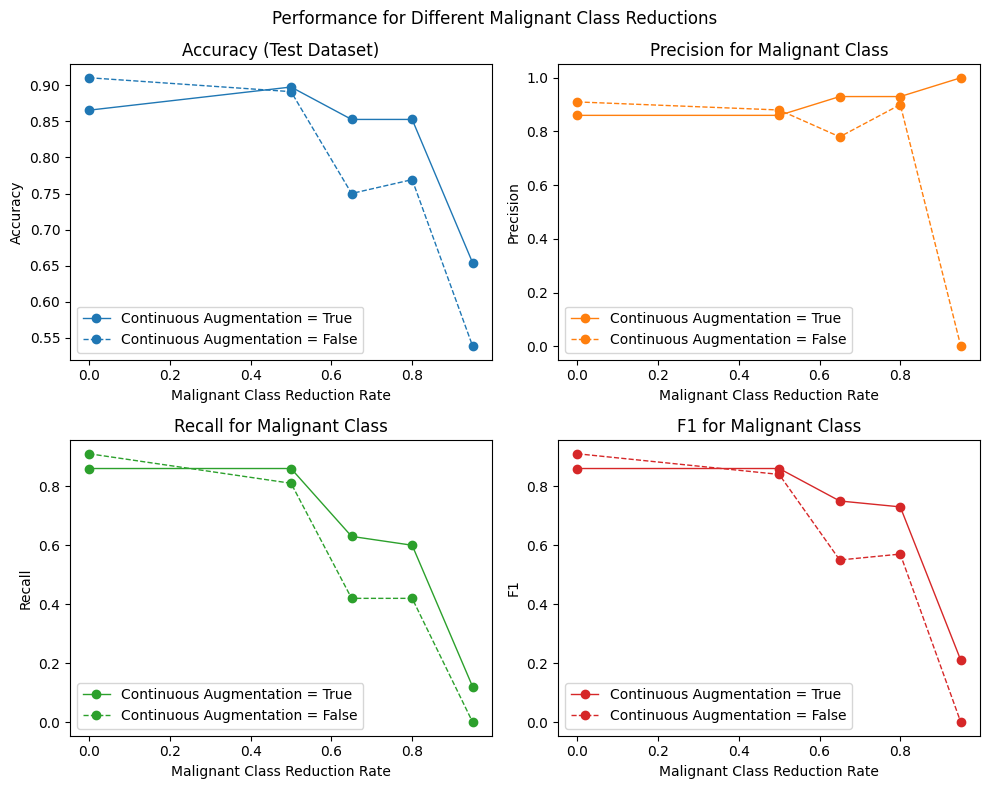

In [40]:
# Separate the dataframe based on continuous_augmentation value
df_true = df_reduction_study[df_reduction_study['continuous_augmentation'] == True]
df_false = df_reduction_study[df_reduction_study['continuous_augmentation'] == False]

# Create a grid of plots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the performance metrics for continuous_augmentation = True
axs[0, 0].plot(df_true['reduce_malignant_rate'], df_true['test_accuracy'], label='Continuous Augmentation = True', color='C0', linewidth=1, marker='o')
axs[0, 0].plot(df_false['reduce_malignant_rate'], df_false['test_accuracy'], '--', label='Continuous Augmentation = False', color='C0', linewidth=1, marker='o')
axs[0, 0].set_title('Accuracy (Test Dataset)')
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].plot(df_true['reduce_malignant_rate'], df_true['malignant_precision'], label='Continuous Augmentation = True', color='C1', linewidth=1, marker='o')
axs[0, 1].plot(df_false['reduce_malignant_rate'], df_false['malignant_precision'], '--', label='Continuous Augmentation = False', color='C1', linewidth=1, marker='o')
axs[0, 1].set_title('Precision for Malignant Class')
axs[0, 1].set_ylabel("Precision")

axs[1, 0].plot(df_true['reduce_malignant_rate'], df_true['malignant_recall'], label='Continuous Augmentation = True', color='C2', linewidth=1, marker='o')
axs[1, 0].plot(df_false['reduce_malignant_rate'], df_false['malignant_recall'], '--', label='Continuous Augmentation = False', color='C2', linewidth=1, marker='o')
axs[1, 0].set_title('Recall for Malignant Class')
axs[1, 0].set_ylabel("Recall")


axs[1, 1].plot(df_true['reduce_malignant_rate'], df_true['malignant_f1'], label='Continuous Augmentation = True', color='C3', linewidth=1, marker='o')
axs[1, 1].plot(df_false['reduce_malignant_rate'], df_false['malignant_f1'], '--', label='Continuous Augmentation = False', color='C3', linewidth=1, marker='o')
axs[1, 1].set_title('F1 for Malignant Class')
axs[1, 1].set_ylabel("F1")

# Set common labels
fig.suptitle('Performance for Different Malignant Class Reductions')

# Add legends to each plot
for ax in axs.flat:
  ax.legend(loc='lower left')
  ax.set_xlabel('Malignant Class Reduction Rate')


# Adjust spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()